In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling1D, Masking, Concatenate, LayerNormalization, MultiHeadAttention, Dropout



In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
import pandas as pd

### Transformer Encoder Architecture


In [ ]:
def transformer_encoder(inputs, num_heads, ff_dim, dropout_rate):
    # Layer normalization 1
    x = LayerNormalization(epsilon=1e-6)(inputs)
    # Multi-head attention
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)(x, x)
    # Skip connection
    x = x + attention_output
    # Dropout
    x = Dropout(dropout_rate)(x)
    # Layer normalization 2
    x = LayerNormalization(epsilon=1e-6)(x)
    # Feed forward network
    ff_output = Dense(ff_dim, activation="relu")(x)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    # Second skip connection
    output = x + ff_output
    # Dropout
    output = Dropout(dropout_rate)(output)
    return output


### Full model

In [ ]:
def create_model(time_series_input_shape, single_meas_input_shape):
    # Time series input and Transformer layer
    time_series_input = Input(shape=time_series_input_shape)
    x = transformer_encoder(time_series_input, num_heads=2, ff_dim=64, dropout_rate=0.1)
    x = GlobalAveragePooling1D()(x)
    time_series_model = Model(inputs=time_series_input, outputs=x)

    # Single measurement input and shallow network
    single_meas_input = Input(shape=(single_meas_input_shape,))
    mask = Masking(mask_value=np.pi)(single_meas_input)
    y = Dense(32, activation='relu')(mask)
    single_meas_model = Model(inputs=single_meas_input, outputs=y)

    # Combining both models
    combined = Concatenate()([time_series_model.output, single_meas_model.output])
    z = Dense(64, activation='relu')(combined)
    z = Dense(32, activation='relu')(z)
    output = Dense(2, activation='softmax')(z)

    model = Model(inputs=[time_series_input, single_meas_input], outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
!pip install -U -q PyDrive2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 1.7 MB/s eta 0:00:00


In [ ]:
from pydrive2.auth import GoogleAuth

from pydrive2.drive import GoogleDrive

from google.colab import auth

from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()

gauth = GoogleAuth()

gauth.credentials = GoogleCredentials.get_application_default()

drive = GoogleDrive(gauth)

In [ ]:
#https://drive.google.com/file/d/1guMuEmfLWFgHwXQTDVXkvTKVYgUh1fzc/view?usp=drive_link
fileDownloaded = drive.CreateFile({'id':'1guMuEmfLWFgHwXQTDVXkvTKVYgUh1fzc'})

In [ ]:
fileDownloaded.GetContentFile('train2.pkl')

In [ ]:
#https://drive.google.com/file/d/1QhtEmzasLyj14y55B7UiKNFuIJZVgdwq/view?usp=drive_link
fileDownloadedbis = drive.CreateFile({'id':'1QhtEmzasLyj14y55B7UiKNFuIJZVgdwq'})
fileDownloadedbis.GetContentFile('test2.pkl')

In [ ]:
# Assume input shapes are known
model = create_model((10, 5), 33)  # Adjust these shapes as necessary
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 10, 5)]              0         []                            
                                                                                                  
 layer_normalization (Layer  (None, 10, 5)                10        ['input_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention (Mult  (None, 10, 5)                2949      ['layer_normalization[0][0]', 
 iHeadAttention)                                                     'layer_normalization[0][0]'] 
                                                                                            

In [ ]:


# Data Preparation
train = pd.read_pickle('train2.pkl').reset_index(drop=True)
N = len(train)
train = train.sample(frac=1).reset_index(drop=True)
val = train[:int(N*0.2)]
train = train[int(N*0.2):]

# Prepare Training Data
y_train = to_categorical(np.asarray(list(train['label'])))
X_train_cont = np.asarray(list(train['X_cont'].values))
X_train_cat = train.drop(['X_cont', 'label'], axis=1)
X_train_cat[X_train_cat.isna()] = np.pi
X_train_cat = np.asarray(list(X_train_cat.values))

# Prepare Validation Data
y_val = to_categorical(np.asarray(list(val['label'])))
X_val_cont = np.asarray(list(val['X_cont'].values))
X_val_cat = val.drop(['X_cont', 'label'], axis=1)
X_val_cat[X_val_cat.isna()] = np.pi
X_val_cat = np.asarray(list(X_val_cat.values))

In [ ]:
print(X_train_cont.shape)  # Should be something like (num_samples, 10, 5)
print(X_train_cat.shape)   # Should be (num_samples, number_of_features)


(1801532, 10, 5)
(1801532, 33)


In [ ]:
# Train the Model
model.fit([X_train_cont, X_train_cat], y_train, validation_data=([X_val_cont, X_val_cat], y_val), epochs=10, batch_size=64)

Epoch 1/10
28149/28149 [==============================] - 319s 11ms/step - loss: 0.0810 - accuracy: 0.9822 - val_loss: 0.0778 - val_accuracy: 0.9826
Epoch 2/10
28149/28149 [==============================] - 294s 10ms/step - loss: 0.0780 - accuracy: 0.9823 - val_loss: 0.0763 - val_accuracy: 0.9826
Epoch 3/10
28149/28149 [==============================] - 309s 11ms/step - loss: 0.0763 - accuracy: 0.9824 - val_loss: 0.0748 - val_accuracy: 0.9827
Epoch 4/10
28149/28149 [==============================] - 294s 10ms/step - loss: 0.0750 - accuracy: 0.9825 - val_loss: 0.0739 - val_accuracy: 0.9827
Epoch 5/10
28149/28149 [==============================] - 307s 11ms/step - loss: 0.0738 - accuracy: 0.9825 - val_loss: 0.0732 - val_accuracy: 0.9829
Epoch 6/10
28149/28149 [==============================] - 304s 11ms/step - loss: 0.0729 - accuracy: 0.9826 - val_loss: 0.0725 - val_accuracy: 0.9829
Epoch 7/10
28149/28149 [==============================] - 305s 11ms/step - loss: 0.0721 - accuracy: 0.9826

In [ ]:
# Load and Prepare Test Data
test = pd.read_pickle('test2.pkl')
y_test = to_categorical(np.asarray(list(test['label'])))
X_test_cont = np.asarray(list(test['X_cont'].values))
X_test_cat = test.drop(['X_cont', 'label'], axis=1)
X_test_cat[X_test_cat.isna()] = np.pi
X_test_cat = np.asarray(list(X_test_cat.values))

# Evaluate the Model
evaluation = model.evaluate([X_test_cont, X_test_cat], y_test)
print(f'Test Loss: {evaluation[0]}, Test Accuracy: {evaluation[1]}')

12554/12554 [==============================] - 59s 5ms/step - loss: 0.0888 - accuracy: 0.9826
Test Loss: 0.08879271894693375, Test Accuracy: 0.9825796484947205


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from sklearn.metrics import auc

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
def roc(predictions, true, filename):
    predictions = predictions.flatten()
    true = true.flatten()

    thresh_vals = np.linspace(np.min(predictions), np.max(predictions), 50)
    results = []
    for thresh in thresh_vals:
        tmp_predictions = (predictions > thresh).astype(int)
        tn, fp, fn, tp = confusion_matrix(true, tmp_predictions).ravel()
        tpr = tp/(tp+fn)
        fpr = fp/(tn+fp)
        acc = (tp+tn)/(tn+fp+fn+tp)

        tmp_dict = {'acc': acc, 'tpr': tpr, 'fpr': fpr, 'thresh': thresh}
        results.append(tmp_dict)

    results = pd.DataFrame(results)
    results = results.sort_values(by='thresh', ascending=False)

    #calculate the AUC
    AUC = auc(results['fpr'].values, results['tpr'].values)

    plt.figure(figsize=(10,6))
    plt.plot(results['fpr'], results['tpr'], '*-')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC\nAUC=%.2f' % AUC)
    plt.tight_layout()
    #plt.savefig('plots/ROC_%s.png' % filename, dpi=250)
    plt.show()

    results = results.sort_values(by='acc', ascending=False)
    final_thresh = results.head(1)['thresh'].values[0]

    return results, final_thresh

14075/14075 [==============================] - 57s 4ms/step


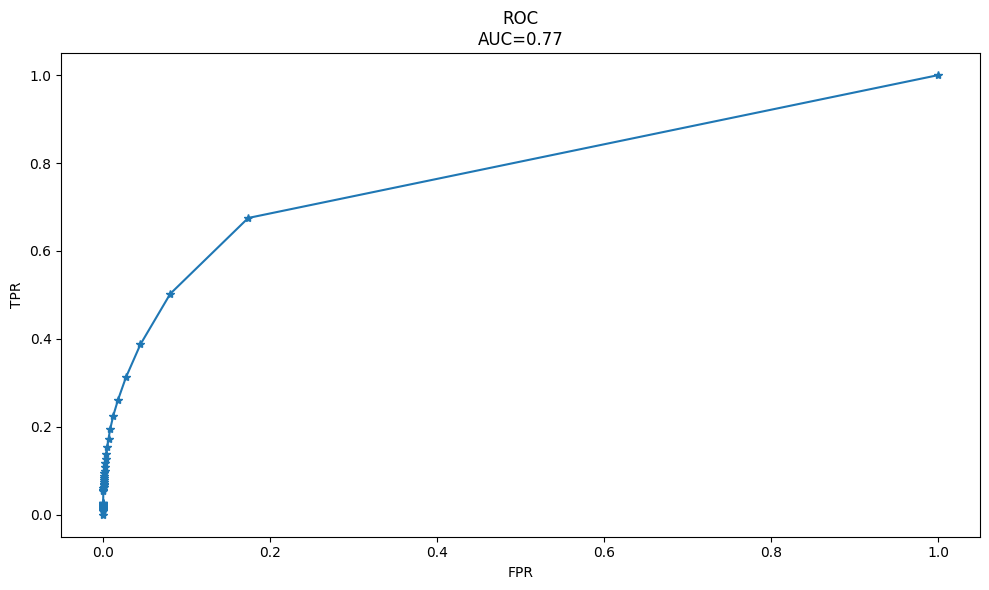

In [ ]:
predictions = model.predict([X_val_cont, X_val_cat])

results_df, thresh_final = roc(predictions[:,1].flatten(), y_val[:,1].flatten(), 'val')
results_df = results_df.sort_values(by='fpr')